# Bee Colony Optimization - Student Programming Task

presented by: Lina Lazik, Sönke Lülf, Hendrik Schmidt

### Context:
You were approached by the government of Lower-Saxony and tasked with helping in planning the (not yet existing) city of Osnabrück. Concretely, your task is to allocate hospitals in the city in such a way that each citizen receives optimal coverage.
The government provided you the coordinates of places where they want to either build housing or hospitals. They want to start building as soon as possible, but therefore they need to know which places will become hospitals. They want you to choose p of the places.
Doing this by hand is quite tedious. But luckily, the BCO algorithm can do most of the work for you. You only have to program it.

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import visualization

locations = visualization.get_locations()

# hyperparameters for the BCO algorithm
num_bees = 70                                                                                           #one bee is the equivalent of a hospital location proposition
num_nodes = len(locations)                                                                              #amount of property locations
NC = 30                                                                                                 #number of iterations
p_centers = 5                                                                                           #amount of hospital locations
hive = np.array([np.random.choice(num_nodes,p_centers,replace=False) for _ in range(num_bees)])         #random initialization of the bees
fitness = np.zeros((num_bees,))                                                                         #initialization of fitness

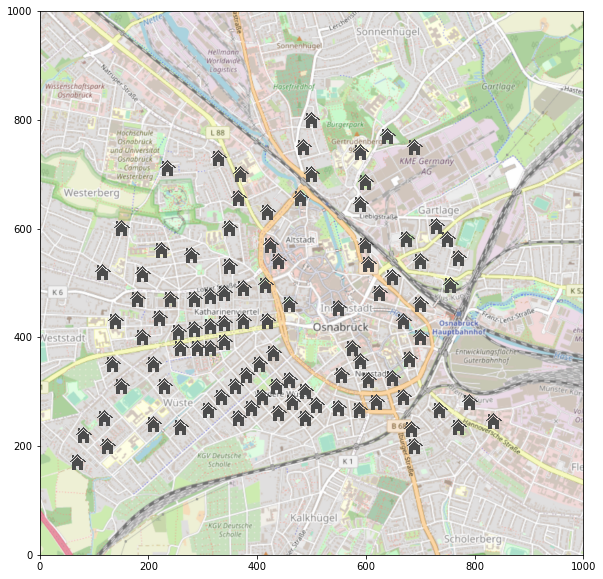

In [2]:
visualization.visualize_solution(locations, [])

[Provided]

(We were inspired by this paper: http://www.mi.sanu.ac.rs/~tanjad/MaksimovicDavidovic_BALCOR2013.pdf and if you have any questions you can ask us in the forum or check this paper for reference.)

Here the properties locations get randomly assigned coordinates. From these locations our centers get randomly selected.

The distance between two locations is represented in a matrix. In Dc the distances are sorted from lowest to highest (left to right) and Ds displayes the normal matrix but with their rank in distance (lowest to highest).

In [3]:
distance = np.empty((num_nodes,num_nodes))                              #calculates the distance between all locations
for i in range(len(distance[0])):
  for j in range(len(distance[1])):
    distance[i,j] = round(math.sqrt((locations[i,0]-locations[j,0])**2 + (locations[i,1]-locations[j,1])**2),2)

dc = np.empty((num_nodes,num_nodes))
ds = np.empty((num_nodes,num_nodes), dtype=int)

for i, row in enumerate(distance):
  dc[i] = np.sort(row)                                                  #sorts the distance-matix in ascending order
  ds[i] = np.argsort(row)                                               #saves the order of the indices of dc

[Provided]

The critical distance provides the information which distance between a houshold location and the nearest hospital center is the maximum distance. To ensure that every houshold has a hospital nearby.

In [4]:
def critical_pair(centers):
  """
    Finds the critical pair in a given set of nodes.
    param:  centers; list, nodes that were chosen as a center
            locations; list, the nodes in the graph
    return: cpair; tuple, location and center that make up the critical pair
            cdist; float, the critical distance
  """
  cdist = 0
  cpair = (0, 0)
  for i, _ in enumerate(locations):
    if not(i in centers):
      for j, val in enumerate(ds[i]):
        if val in centers:
          dist = dc[i,j]
          if dist > cdist:
            cdist = dc[i,j]
            cpair = (i,val)
          break
  return cpair, cdist

### [Programming Task 1]

Before we can check if the locations of the hospitals are the best ones from all the locations we need to temporally increase the number of hospital location, expanding the amount of number for hospital centers. 
Since you guys now have to many hospital centers you need to compare which hospitals can be removed from the set, without drastically increasing the critical distance. (This strategy is not guaranteed to find a solution at least as good as the original one so you might want to check for that and discard a worse solution.)

Keep in mind, that at the end of this function, you should only have 5(or the number you picked at the beginning) centers.


In [5]:
def expand_centers(centers):
    """
      Finds the critical pair in a given set of nodes.
      param:  centers; ndarray, nodes that were chosen as a center
              p_centers; int, the number of centers
              num_nodes; int, the number of nodes in the graph
      return: expanded_centers; ndarray, the expanded centers
    """

    old_centers = centers.copy() # save old centers in case our solution gets worse
    expansion_amount = random.randrange(1,6)
    le_center=len(old_centers)+expansion_amount

    while(len(centers)<le_center):
        new_center=np.random.choice(num_nodes)
        if new_center not in centers:
            centers=np.append(centers,new_center)

    while(len(centers) > p_centers):
        crit_new=critical_pair(centers)
        worst_index=np.where(centers==crit_new[0][1])
        centers=np.delete(centers,worst_index)

    old_center_ev=critical_pair(old_centers)
    new_center_ev=critical_pair(centers)
  
    if old_center_ev[1]<new_center_ev[1]:
        return old_centers
    else:
        return centers


### [Programming Task 2.1]

At some point in the backward pass, the bees will have to calculate their loyalty for their own solution. In order for this calculation to return a meaningful result, the bees have to normalize their fitness score. In the cell below you are asked to implement this normalization. [Hint: Consider whether you want to minimize or maximize the fitness function]

In [6]:
def normalize_value(objective, value, max_fitness, min_fitness):
    """
      This function normalizes the fitness value of a bee's partial solution depending on whether the fitness function is supposed to be minimized or maximized.
      
      param:  objective; string, indicates what kind of problem we are dealing with
              value; float, the current bees fitness value
              max_fitness; float, the highest fitness score
              min_fitness; float, the lowest fitness score
      
      return: normalized_fitness; float, the normalized fitness score
    """
    #YOUR CODE HERE
    normalized_fitness=0

    if max_fitness == min_fitness:
        return 1
    if objective=="max":
        normalized_fitness=(min_fitness-value)/(min_fitness-max_fitness)
    else:
        normalized_fitness=(max_fitness-value)/(max_fitness-min_fitness)
        
    return normalized_fitness

        

### [Programming Task 2.2]

Now, that the bees can determine their loyalty to their own function appropriately, you will have to help the very loyal ones (those bees, that stick with their solution) to attract new bees to their solution. You can use the formula from the slides to assign each recruiter a probability that their solution will be chosen by any uncommitted bee.

In [7]:
def create_roulette_wheel(recruiters, fitness):
    """
      This function calculates the probability that a recruiters' partial solution is choosen by an uncommitted bee.

      param:  recruiters; list, stores all the bees that have become recruiters. The bees are represented by their index in the hive
              fitness; ndarray, all of the bees' fitness values
              
      return: roulette_wheel; list, holds the probability for each recruiter that his solution will be chosen by the uncommitted bees
    """
    """norm_fit=[]
    
    for cost in fitness:
        norm_fit.append(normalize_value("min",cost, max(fitness), min(fitness)))
        
    ok=sum(norm_fit)
    return np.divide(norm_fit,ok)"""
    ok = sum(fitness)
    return(np.divide(fitness,ok))
    
    
    

### [Provided]

This is the froward pass where every bee expands its chosen centers.

In [8]:
def forward_pass(hive):
    """
      This function implements the forward pass for the BCO. Each bee expands its centers and stores the new solution

      param: hive; ndarray, stores all the bees
             
    """
    for ind_bee in range(num_bees):
        hive[ind_bee] = expand_centers(hive[ind_bee])
        

### [Programming Task 3]

You now have to implement the backward pass. This is the part where every bee in the hive decides whether it wants to stay loyal to their solution or maybe adopt another bee's solution. 



In [9]:
def backward_pass(objective, nc, hive):
    """
      This function implements the backward pass for the BCO algorithm. It proceeds in the following steps:
          1. It calculates the fitness for all the bees' solutions and identifies minimum and maximum values.
          2. For each bee, it calculates the probability that it will stick with it's own function (loyalty) and decides
             whether they become uncommitted (exploration) or a recruiter (exploitation)
          3. For every uncommitted bee, it decides which recruiter they will follow.

      param: objective; string, indicates what kind of problem we are dealing with
             nc; int, the number of the current iteration
             hive; ndarray, all the bees in one place

      return: min_fitness; float, the smallest critical distance found so far and therefore the best solution
              best_bee; ndarray, the best bee's solution
    """
    #1) calculate fitness for all the bees solutions, identify min, max value
    # calculate cb, for that go through all the elements in the hive and sum up the costs
    costs=[]
    for bee in hive:
        #compute the critical distance for each hive of a bee 
        costs.append(critical_pair(bee)[1])
        
    #compute min and max value
    min_value=min(costs)
    
    max_value=max(costs)
    
    cost_normalized=[]
    
    for cost in costs:
        cost_normalized.append(normalize_value("min", cost, max_value, min_value))

    omax=max(cost_normalized)
    prob_loyal=[]
    for cost_n in cost_normalized:
        prob_loyal.append(math.exp(-(omax-cost_n)/(nc)))
    

    # 3) apply create_roulette_wheel
    # decide whether you wanna follow or not
    # store uncommitted bees
    """uncommitted_bees=[]
    recruiters_fitness=[]
    recruiters=[]
    recruiters_index = []
    
    bee_counter=0
    for prob_lo in prob_loyal:
        decision=random.choices([0,1], weights=[prob_lo, 1-prob_lo], k=1)
       
        if decision[0]==1:
            uncommitted_bees.append(hive[bee_counter])

        else:
            recruiters.append(list(hive[bee_counter]))
            recruiters_index.append(bee_counter)
            recruiters_fitness.append(cost_normalized[bee_counter])
        bee_counter=bee_counter+1
    
    
    recruiting_probability = create_roulette_wheel(recruiters, recruiters_fitness)
    new_hive = recruiters.copy()
    #print(recruiters)
    #print(type(hive))
    for _ in uncommitted_bees:
        
        choice = np.random.choice(recruiters_index, p=list(recruiting_probability))
        new_hive.append(list(hive[choice]))
    #print(new_hive)   

        
    hive = new_hive.copy()
    
    index=np.argmin(costs)
    return min_value, hive[index]"""
    uncommitted_bees_index=[]
    recruiters=[]
    recruiters_index=[]
    recruiters_fitness=[]
    for index, prob_lo in enumerate(prob_loyal):
        decision=random.choices([0,1], weights=[prob_lo, 1-prob_lo], k=1)
        if decision[0]==1:
            uncommitted_bees_index.append(index)
        else:
            recruiters.append(hive[index])
            recruiters_index.append(index)
            recruiters_fitness.append(costs[index])

    recruiting_probability = create_roulette_wheel(recruiters, recruiters_fitness)

    for ub_index in uncommitted_bees_index:
        choice = np.random.choice(a=recruiters_index, size=1, p=list(recruiting_probability))
        hive[ub_index] = hive[choice]
    
    
    index=np.argmin(costs)

    return min_value, hive[index]

### [Provided]
This is where you put everything together.

In [10]:
def BCO():
  best = []
  best_bee = []
  for i in range(NC):
    forward_pass(hive)
    curr_best, curr_bee = backward_pass("min", i+1, hive) 
    best.append(curr_best)
    best_bee.append(curr_bee)
    print(f"The best bee in iteration {i} has a score of: {curr_best}")

  return best_bee[NC-1]        

The best bee in iteration 0 has a score of: 263.15
The best bee in iteration 1 has a score of: 263.15
The best bee in iteration 2 has a score of: 263.15
The best bee in iteration 3 has a score of: 263.15
The best bee in iteration 4 has a score of: 263.15
The best bee in iteration 5 has a score of: 263.15
The best bee in iteration 6 has a score of: 263.15
The best bee in iteration 7 has a score of: 263.15
The best bee in iteration 8 has a score of: 263.15
The best bee in iteration 9 has a score of: 263.15
The best bee in iteration 10 has a score of: 263.15
The best bee in iteration 11 has a score of: 263.15
The best bee in iteration 12 has a score of: 263.15
The best bee in iteration 13 has a score of: 263.15
The best bee in iteration 14 has a score of: 263.15
The best bee in iteration 15 has a score of: 252.98
The best bee in iteration 16 has a score of: 252.98
The best bee in iteration 17 has a score of: 252.98
The best bee in iteration 18 has a score of: 252.98
The best bee in iterat

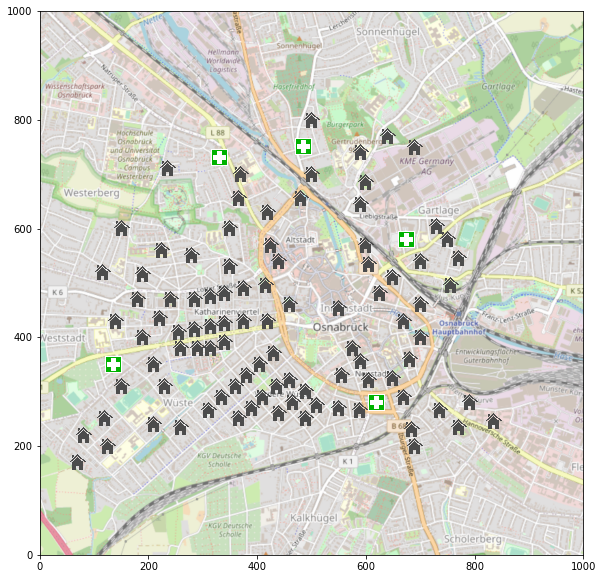

In [11]:
#for randomizing hive every time
#DELETE LATER
hive = np.array([np.random.choice(num_nodes,p_centers,replace=False) for _ in range(num_bees)])
#for i in range(2):
 #   visualization.visualize_solution(locations,hive[i])
best = BCO()
visualization.visualize_solution(locations,best)
